In [10]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from textblob import TextBlob
import folium
import numpy as np


# Load the provided CSV files
listings_path = './listings.csv'
reviews_path = './reviews.csv'
calendar_path = './calendar.csv'
neighbourhoods_path ='./neighbourhoods.csv'

# Read the files into pandas dataframes
listings_df = pd.read_csv(listings_path)
reviews_df = pd.read_csv(reviews_path)
calendar_df = pd.read_csv(calendar_path)
neighbourhoods_df = pd.read_csv(neighbourhoods_path)

# Display the first few rows of each dataframe to understand their structure
listings_head = listings_df.head()
reviews_head = reviews_df.head()
calendar_head = calendar_df.head()

listings_head, reviews_head, calendar_head, neighbourhoods_df

(        id                                               name   host_id  \
 0  1489424  Home in Albany · ★4.73 · 1 bedroom · 1 bed · 1...   5294164   
 1  2992450  Rental unit in Albany · ★3.56 · 2 bedrooms · 2...   4621559   
 2  3820211  Rental unit in Albany · ★4.75 · 1 bedroom · 1 ...  19648678   
 3  5651579  Rental unit in Albany · ★4.51 · Studio · 1 bed...  29288920   
 4  6623339  Rental unit in Albany · ★4.73 · 1 bedroom · 1 ...  19648678   
 
   host_name  neighbourhood_group    neighbourhood  latitude  longitude  \
 0     Efrat                  NaN  FOURTEENTH WARD  42.66719  -73.81580   
 1   Kenneth                  NaN       THIRD WARD  42.65789  -73.75370   
 2     Terra                  NaN       SIXTH WARD  42.65222  -73.76724   
 3     Gregg                  NaN      SECOND WARD  42.64615  -73.75966   
 4     Terra                  NaN       SIXTH WARD  42.65222  -73.76724   
 
          room_type  price  minimum_nights  number_of_reviews last_review  \
 0     Privat

In [11]:
datasets_info = {
    "calendar.csv": {
        "total_records": calendar_df.shape[0],
        "attributes": calendar_df.dtypes.to_dict()
    },
    "listings.csv": {
        "total_records": listings_df.shape[0],
        "attributes": listings_df.dtypes.to_dict()
    },
    "neighbourhoods.csv": {
        "total_records": neighbourhoods_df.shape[0],
        "attributes": neighbourhoods_df.dtypes.to_dict()
    },
    "reviews.csv": {
        "total_records": reviews_df.shape[0],
        "attributes": reviews_df.dtypes.to_dict()
    }
}

datasets_info


{'calendar.csv': {'total_records': 142715,
  'attributes': {'listing_id': dtype('int64'),
   'date': dtype('O'),
   'available': dtype('O'),
   'price': dtype('O'),
   'adjusted_price': dtype('O'),
   'minimum_nights': dtype('int64'),
   'maximum_nights': dtype('int64')}},
 'listings.csv': {'total_records': 391,
  'attributes': {'id': dtype('int64'),
   'name': dtype('O'),
   'host_id': dtype('int64'),
   'host_name': dtype('O'),
   'neighbourhood_group': dtype('float64'),
   'neighbourhood': dtype('O'),
   'latitude': dtype('float64'),
   'longitude': dtype('float64'),
   'room_type': dtype('O'),
   'price': dtype('int64'),
   'minimum_nights': dtype('int64'),
   'number_of_reviews': dtype('int64'),
   'last_review': dtype('O'),
   'reviews_per_month': dtype('float64'),
   'calculated_host_listings_count': dtype('int64'),
   'availability_365': dtype('int64'),
   'number_of_reviews_ltm': dtype('int64'),
   'license': dtype('float64')}},
 'neighbourhoods.csv': {'total_records': 16,
  '

In [12]:
# total number of rows in calender df
listings_df.shape

(391, 18)

In [13]:
# Handling missing values
listings_df = listings_df.dropna(subset=['price', 'room_type', 'neighbourhood'])
# Remove the dollar sign and commas from the price column
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)
# Remove the duplicate rows
listings_df = listings_df.drop_duplicates()
listings_clean_summary = pd.DataFrame({
    "Missing Values": listings_df.isnull().sum(),
    "Percentage": (listings_df.isnull().sum() / len(listings_df) * 100).round(2),
    "Data Type": listings_df.dtypes
})

listings_clean_summary, listings_df.shape


(                                Missing Values  Percentage Data Type
 id                                           0        0.00     int64
 name                                         0        0.00    object
 host_id                                      0        0.00     int64
 host_name                                    0        0.00    object
 neighbourhood_group                        391      100.00   float64
 neighbourhood                                0        0.00    object
 latitude                                     0        0.00   float64
 longitude                                    0        0.00   float64
 room_type                                    0        0.00    object
 price                                        0        0.00   float64
 minimum_nights                               0        0.00     int64
 number_of_reviews                            0        0.00     int64
 last_review                                 46       11.76    object
 reviews_per_month  

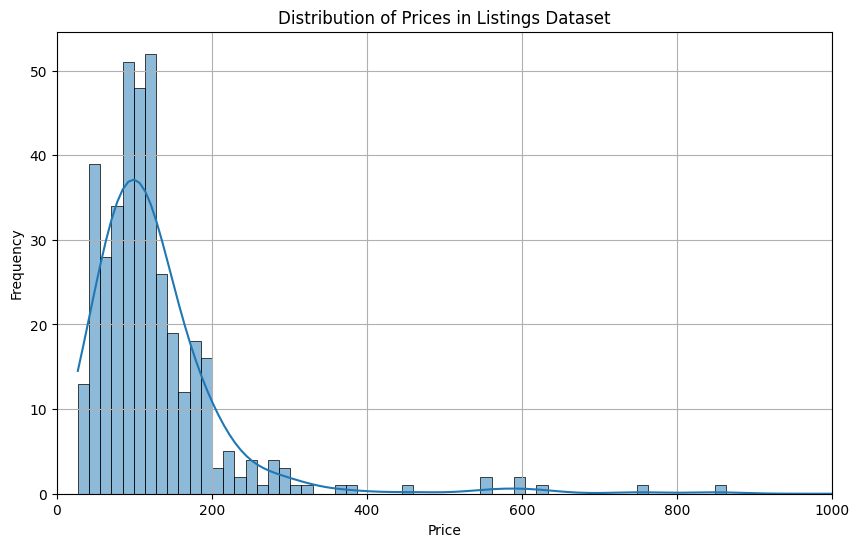

In [14]:
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)
# Feature Engineering
listings_df['room_type_code'] = listings_df['room_type'].astype('category').cat.codes
listings_price_desc = listings_df['price'].describe()

plt.figure(figsize=(10, 6))
sns.histplot(listings_df['price'], bins=100, kde=True)
plt.title('Distribution of Prices in Listings Dataset')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.grid(True)
plt.show()


<ipython-input-19-26c0afd3bc8f>:8: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Price ($)')


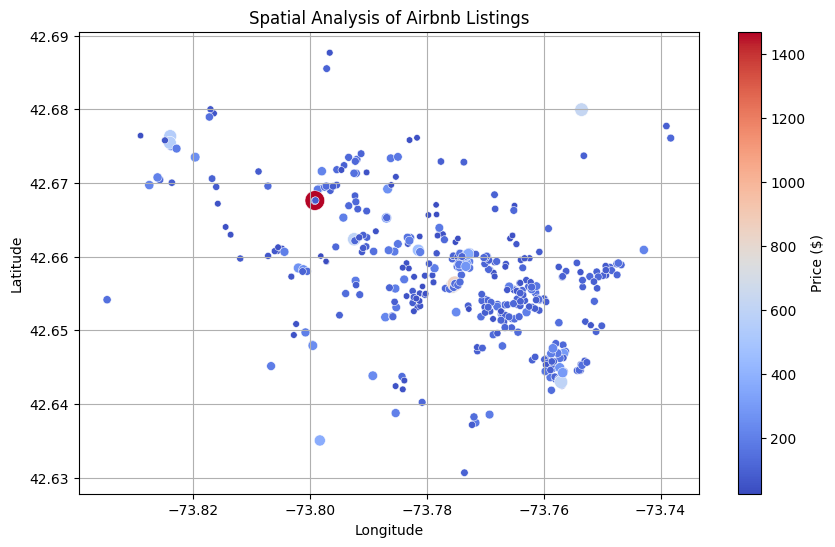

In [19]:
# Correcting the colorbar issue in the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x=listings_df['longitude'], y=listings_df['latitude'], size=listings_df['price'], hue=listings_df['price'], palette="coolwarm", sizes=(20, 200), legend=False)

# Adding a colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=min(listings_df['price']), vmax=max(listings_df['price'])))
sm.set_array([])
plt.colorbar(sm, label='Price ($)')

plt.title("Spatial Analysis of Airbnb Listings")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


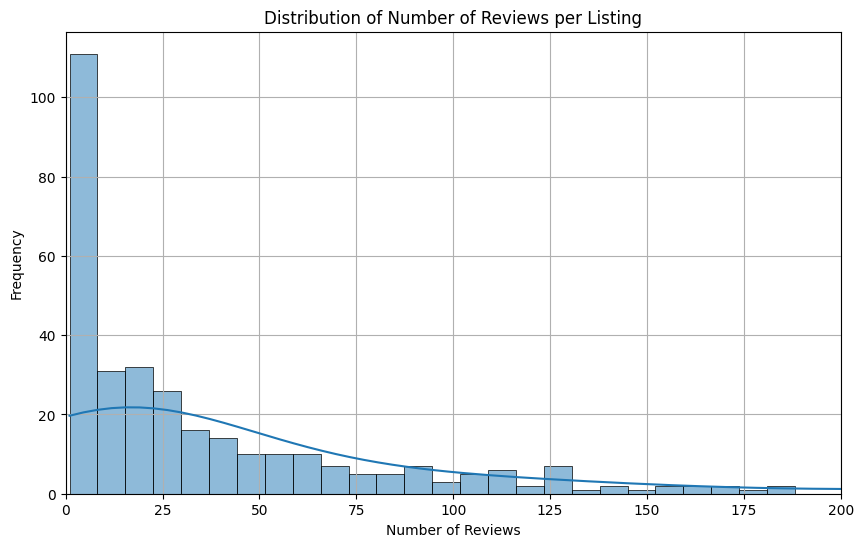

In [5]:
reviews_count = reviews_df['listing_id'].value_counts()
reviews_count_desc = reviews_count.describe()

plt.figure(figsize=(10, 6))
sns.histplot(reviews_count, bins=100, kde=True)
plt.title('Distribution of Number of Reviews per Listing')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.xlim(0, 200)
plt.grid(True)
plt.show()

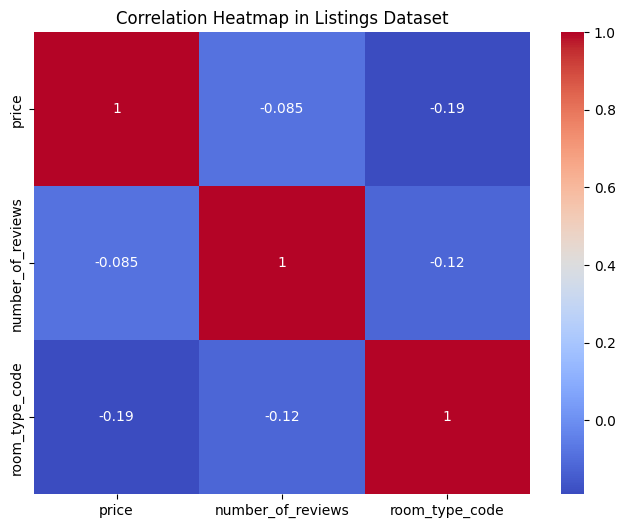

In [ ]:
listings_corr = listings_df[['price', 'number_of_reviews', 'room_type_code']].dropna()
plt.figure(figsize=(8, 6))
sns.heatmap(listings_corr.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap in Listings Dataset')
plt.show()

In [ ]:
listings_price_desc, reviews_count_desc

(count     391.000000
 mean      129.905371
 std       115.679747
 min        27.000000
 25%        78.500000
 50%       106.000000
 75%       144.500000
 max      1470.000000
 Name: price, dtype: float64,
 count    345.000000
 mean      58.200000
 std       97.344826
 min        1.000000
 25%        6.000000
 50%       22.000000
 75%       64.000000
 max      721.000000
 Name: listing_id, dtype: float64)

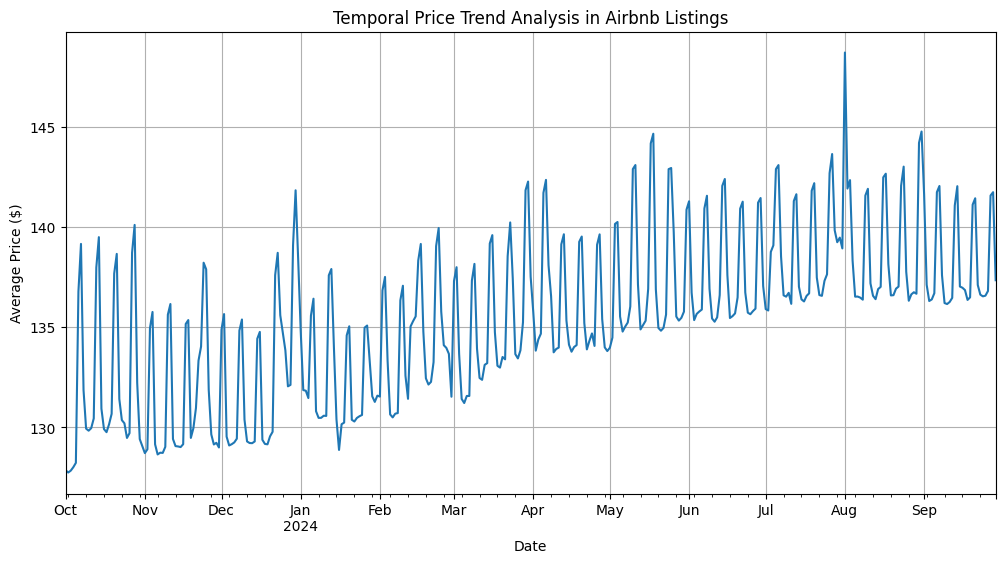

In [21]:


# Converting date strings to datetime objects for proper time-series analysis
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Cleaning and standardizing price formats
# Removing symbols like $ and converting to numerical values
calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Grouping by date and calculating the average price per day
average_prices_per_day = calendar_df.groupby('date')['price'].mean()

# Creating a time-series plot for temporal price trend analysis
plt.figure(figsize=(12, 6))
average_prices_per_day.plot(kind='line')
plt.title("Temporal Price Trend Analysis in Airbnb Listings")
plt.xlabel("Date")
plt.ylabel("Average Price ($)")
plt.grid(True)
plt.show()


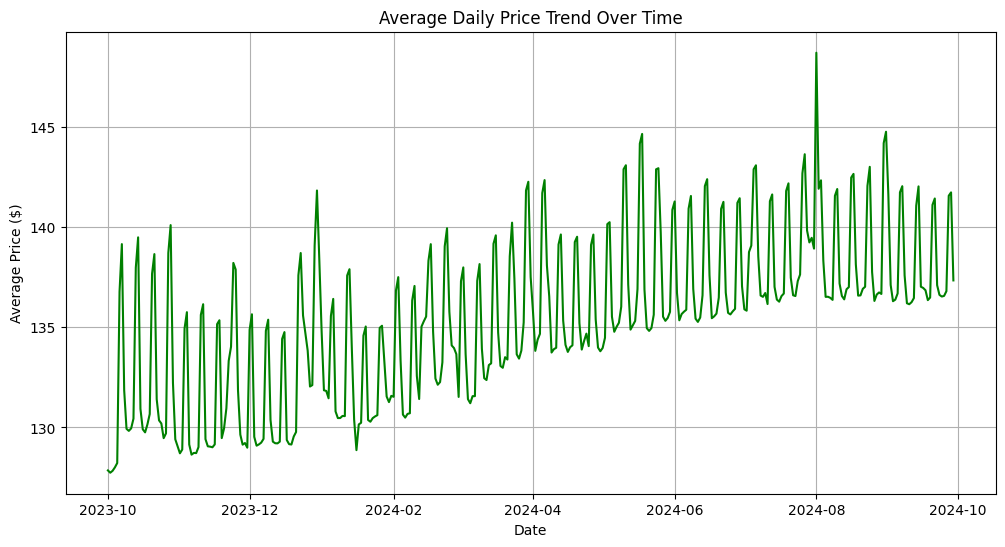

In [ ]:

calendar_df['price'] = calendar_df['price'].replace('[\$,]', '', regex=True).astype(float)
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

trend_data = calendar_df.groupby(calendar_df['date'])['price'].mean().reset_index()

# Plotting the trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_data, x='date', y='price', color='green')
plt.title('Average Daily Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Average Price ($)')

# Formatting the x-axis to display dates as 'YYYY-MM' and to show every second month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.grid(True)
plt.show()

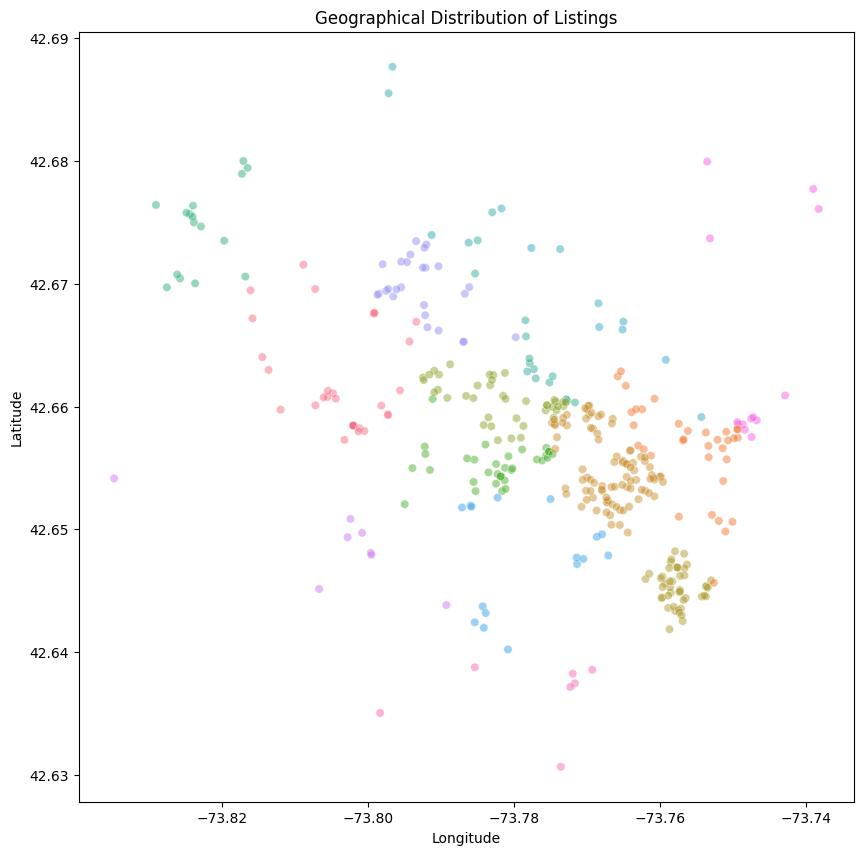

In [ ]:
if 'latitude' in listings_df.columns and 'longitude' in listings_df.columns:
    plt.figure(figsize=(10, 10))
    sns.scatterplot(data=listings_df, x='longitude',alpha=0.5, y='latitude', hue='neighbourhood', legend=False)
    plt.title('Geographical Distribution of Listings')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    geo_analysis_possible = False
    print("Geographical data (latitude and longitude) not available for analysis.")

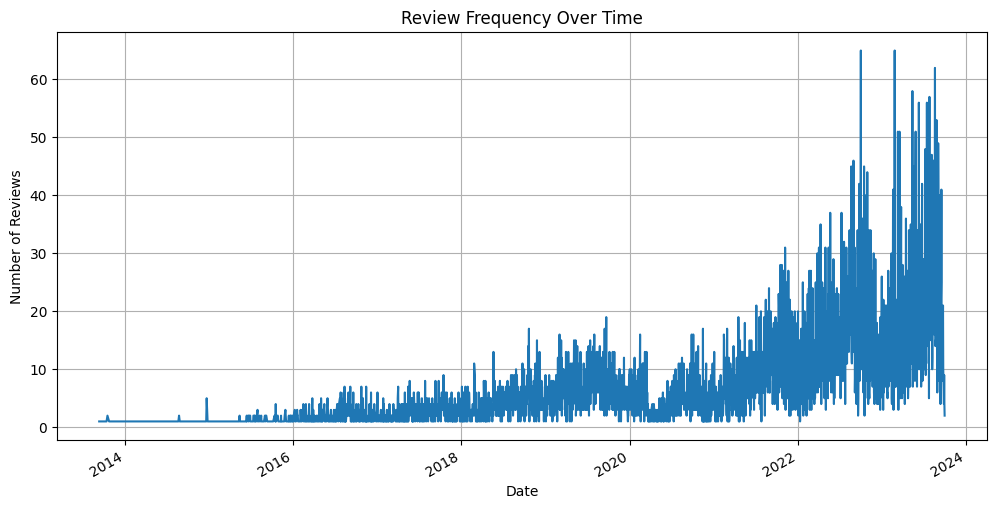

In [22]:
# Since the reviews dataset does not contain the actual review texts, we cannot perform a traditional sentiment analysis.
# However, we can still explore the dataset to find insights. One approach might be to analyze the frequency of reviews over time,
# which can indirectly indicate guest activity and interest.

# Converting the 'date' column to datetime for analysis
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

# Grouping by date to count the number of reviews per day
reviews_count_per_day = reviews_df.groupby('date').size()

# Creating a time-series plot for the frequency of reviews
plt.figure(figsize=(12, 6))
reviews_count_per_day.plot(kind='line')
plt.title("Review Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()


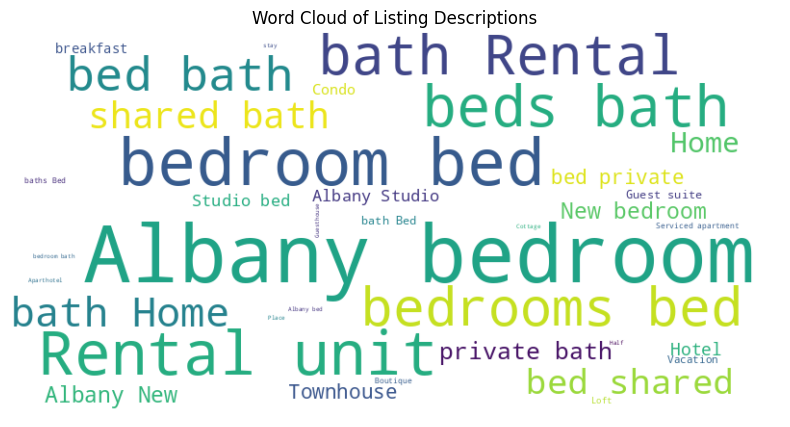

In [23]:

from wordcloud import WordCloud

text_data = " ".join(description for description in listings_df['name'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Listing Descriptions")
plt.show()


In [ ]:
# Review Sentiment Analysis
if 'comments' in reviews_df.columns:
    sample_reviews = reviews_df['comments'].sample(500, random_state=1).dropna()

    sample_reviews_sentiment = sample_reviews.apply(lambda x: TextBlob(x).sentiment.polarity)

    plt.figure(figsize=(10, 6))
    sns.histplot(sample_reviews_sentiment, bins=50, kde=True)
    plt.title('Sentiment Distribution of Review Comments')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Number of Reviews')
    plt.show()

In [ ]:
# Displaying a few neighborhood names to understand their format and presence
sample_neighborhoods = listings_df['neighbourhood'].unique()[:10]
sample_neighborhoods

array(['FOURTEENTH WARD', 'THIRD WARD', 'SIXTH WARD', 'SECOND WARD',
       'TENTH WARD', 'NINTH WARD', 'FIFTEENTH WARD', 'ELEVENTH WARD',
       'TWELFTH WARD', 'FIFTH WARD'], dtype=object)

In [ ]:

# Re-defining the neighborhoods since they were lost in the previous cell
neighborhood1 = 'FOURTEENTH WARD'
neighborhood2 = 'FIFTH WARD'
# Checking the data type of the 'price' column
price_column_dtype = listings_df['price'].dtype

# If the 'price' column is not numeric, convert it to string and clean it
if not pd.api.types.is_numeric_dtype(price_column_dtype):
    listings_df['price'] = listings_df['price'].astype(str).str.replace('[\$,]', '', regex=True)
    listings_df['price'] = pd.to_numeric(listings_df['price'], errors='coerce')

# Drop rows where 'price' is NaN after conversion
listings_df = listings_df.dropna(subset=['price'])

# Perform the same t-test as before
if neighborhood1 in listings_df['neighbourhood'].unique() and neighborhood2 in listings_df['neighbourhood'].unique():
    neighborhood1_prices = listings_df[listings_df['neighbourhood'] == neighborhood1]['price']
    neighborhood2_prices = listings_df[listings_df['neighbourhood'] == neighborhood2]['price']

    if neighborhood1_prices.empty or neighborhood2_prices.empty:
        message = "One or both selected neighborhoods have no listings."
    elif neighborhood1_prices.nunique() == 1 or neighborhood2_prices.nunique() == 1:
        message = "One or both selected neighborhoods have no price variation."
    else:
        # Performing the t-test
        t_stat, p_value = stats.ttest_ind(neighborhood1_prices, neighborhood2_prices, equal_var=False, nan_policy='omit')
        message = f"T-Statistic: {t_stat}\nP-Value: {p_value}"
else:
    message = f"Neighborhoods '{neighborhood1}' and '{neighborhood2}' not found in dataset."

message




'T-Statistic: 0.997488118430084\nP-Value: 0.32562894677731524'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Clean 'price' column
listings_df['price'] = listings_df['price'].astype(str).str.replace('[\$,]', '', regex=True)
listings_df['price'] = pd.to_numeric(listings_df['price'], errors='coerce')
listings_df = listings_df.dropna(subset=['price'])

# Selecting features
features = ['latitude', 'longitude', 'room_type', 'minimum_nights',
            'number_of_reviews', 'reviews_per_month', 'availability_365']
X = listings_df[features]
y = listings_df['price']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['latitude', 'longitude', 'minimum_nights',
                    'number_of_reviews', 'reviews_per_month', 'availability_365']
categorical_features = ['room_type']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model pipeline with Random Forest Regressor
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

# Training the model
model.fit(X_train, y_train)

# Predicting and evaluating
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Outputting the evaluation metrics
print("MSE:", mse)
print("R² score:", r2)

MSE: 11669.472332911391
R² score: 0.0976420694590775


# Neighborhood Popularity Analysis: Determine which neighborhoods are most popular among renters, based on the number of listings and reviews.

In [ ]:


# Identify the neighborhood column
neighborhood_col = 'neighbourhood'

# Grouping listings by neighborhood and counting
neighborhood_listing_counts = listings_df[neighborhood_col].value_counts()

# Grouping reviews by listing id and counting
review_counts = reviews_df['listing_id'].value_counts()

# Merging review counts with the listings dataframe to associate them with neighborhoods
listings_with_review_counts = listings_df.merge(review_counts.rename('review_count'), left_on='id', right_index=True)

# Grouping by neighborhood and summing review counts
neighborhood_review_counts = listings_with_review_counts.groupby(neighborhood_col)['review_count'].sum().sort_values(ascending=False)

# Top neighborhoods based on listings and reviews
top_neighborhoods_by_listings = neighborhood_listing_counts.head(10)
top_neighborhoods_by_reviews = neighborhood_review_counts.head(10)

print("Top Neighborhoods by Number of Listings:")
print(top_neighborhoods_by_listings)

print("\nTop Neighborhoods by Number of Reviews:")
print(top_neighborhoods_by_reviews)


Top Neighborhoods by Number of Listings:
SIXTH WARD         90
SECOND WARD        46
TENTH WARD         40
NINTH WARD         35
THIRD WARD         34
FOURTEENTH WARD    32
THIRTEENTH WARD    26
FIFTEENTH WARD     16
SEVENTH WARD       16
ELEVENTH WARD      15
Name: neighbourhood, dtype: int64

Top Neighborhoods by Number of Reviews:
neighbourhood
SIXTH WARD         5122
SECOND WARD        3916
FOURTEENTH WARD    2088
NINTH WARD         1384
THIRD WARD         1238
SEVENTH WARD       1205
TENTH WARD         1197
FOURTH WARD         718
THIRTEENTH WARD     701
FIFTEENTH WARD      690
Name: review_count, dtype: int64


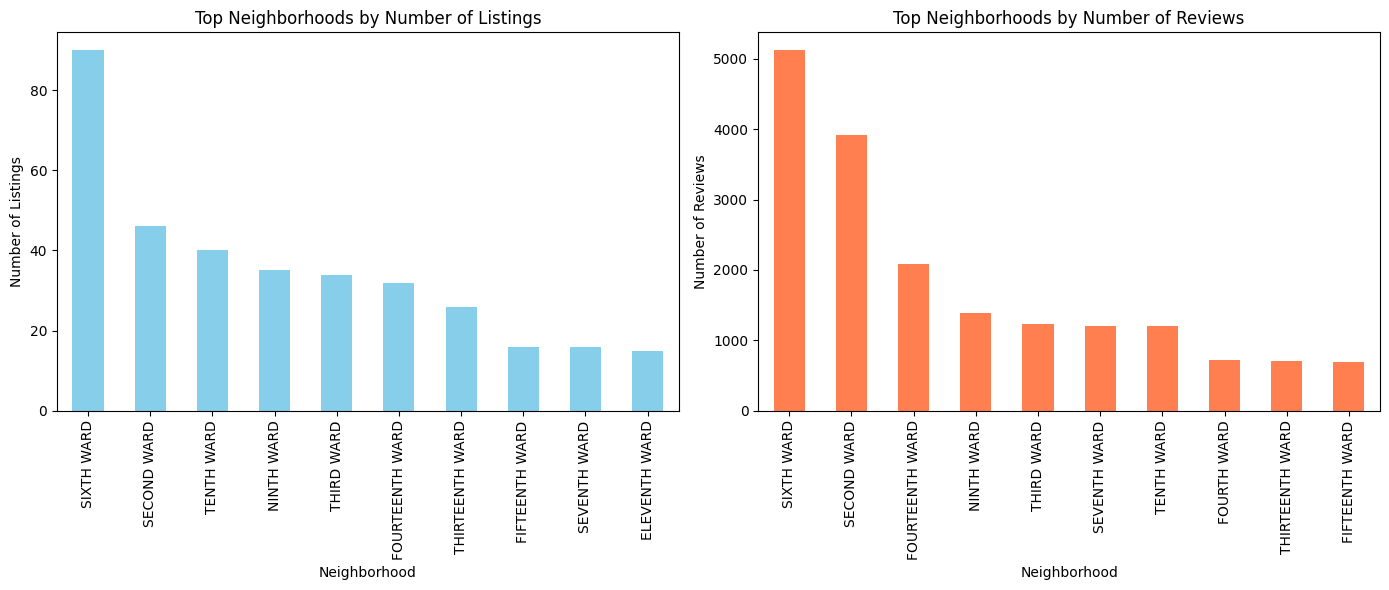

In [ ]:
# Using 'neighbourhood' for the analysis
neighborhood_col = 'neighbourhood'

# Grouping listings by neighborhood and counting
neighborhood_listing_counts = listings_df[neighborhood_col].value_counts()

# Grouping reviews by listing id and counting
review_counts = reviews_df['listing_id'].value_counts()

# Merging review counts with the listings dataframe to associate them with neighborhoods
listings_with_review_counts = listings_df.merge(review_counts.rename('review_count'), left_on='id', right_index=True)

# Grouping by neighborhood and summing review counts
neighborhood_review_counts = listings_with_review_counts.groupby(neighborhood_col)['review_count'].sum().sort_values(ascending=False)

# Preparing data for the top 10 neighborhoods based on listings and reviews
top_neighborhoods_by_listings = neighborhood_listing_counts.head(10)
top_neighborhoods_by_reviews = neighborhood_review_counts.head(10)

# Visualizing the results
plt.figure(figsize=(14, 6))

# Plot for top neighborhoods by number of listings
plt.subplot(1, 2, 1)
top_neighborhoods_by_listings.plot(kind='bar', color='skyblue')
plt.title('Top Neighborhoods by Number of Listings')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')

# Plot for top neighborhoods by number of reviews
plt.subplot(1, 2, 2)
top_neighborhoods_by_reviews.plot(kind='bar', color='coral')
plt.title('Top Neighborhoods by Number of Reviews')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Reviews')

# Displaying the plots
plt.tight_layout()
plt.show()


### Price-Room Type Relationship: Investigate how room types (e.g., entire home, private room) affect pricing across different neighborhoods.


In [ ]:
# Data Analysis: Grouping by neighborhood and room type, and calculating the average price
average_prices = listings_df.groupby(['neighbourhood', 'room_type'])['price'].mean().reset_index()

# Sorting the results for better readability
average_prices_sorted = average_prices.sort_values(by=['neighbourhood', 'room_type'])

average_prices_sorted.head(10)  # Displaying the first 10 rows for a preview

,neighbourhood,room_type,price
0,EIGHTH WARD,Entire home/apt,196.000000
1,EIGHTH WARD,Private room,55.000000
2,ELEVENTH WARD,Entire home/apt,180.400000
3,ELEVENTH WARD,Private room,54.600000
4,FIFTEENTH WARD,Entire home/apt,238.750000
5,FIFTEENTH WARD,Private room,59.000000
6,FIFTH WARD,Entire home/apt,97.714286
7,FIFTH WARD,Private room,68.500000
8,FIRST WARD,Entire home/apt,181.428571
9,FOURTEENTH WARD,Entire home/apt,235.153846


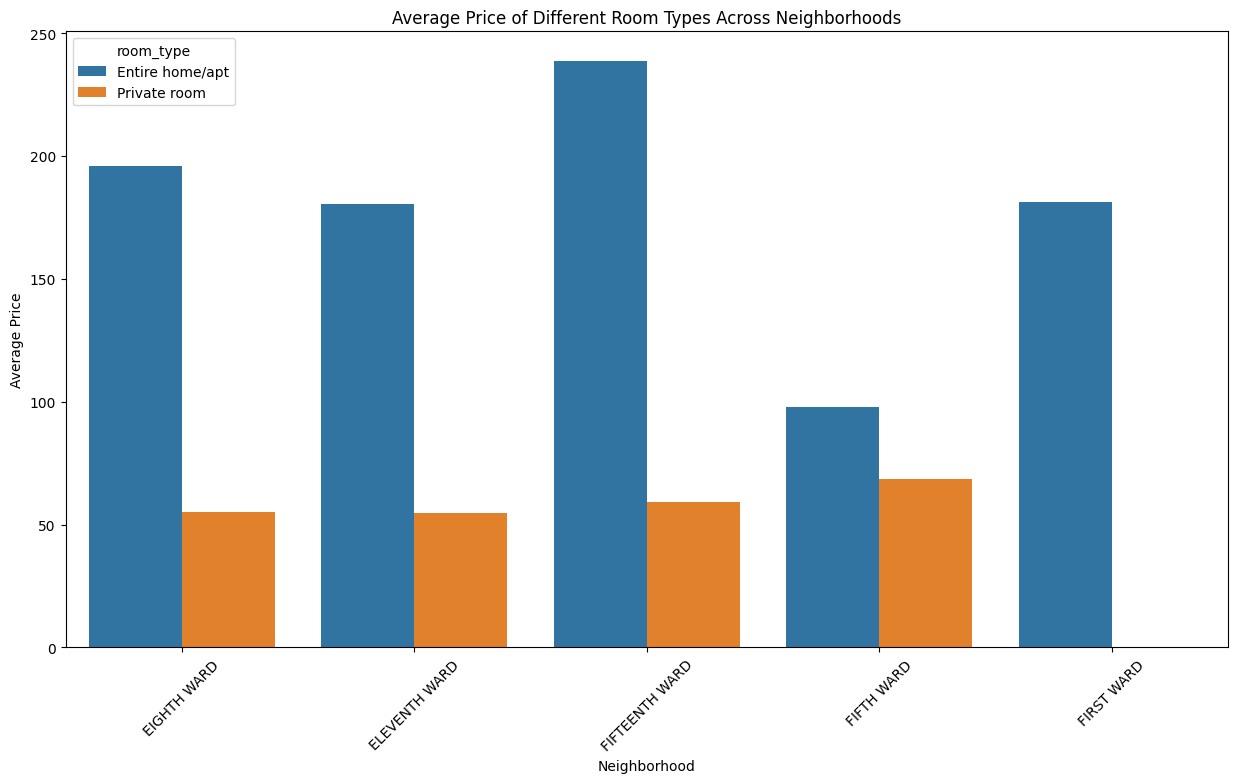

In [ ]:
visualization_data = average_prices_sorted[average_prices_sorted['neighbourhood'].isin(average_prices_sorted['neighbourhood'].unique()[:5])]

# Creating the plot
plt.figure(figsize=(15, 8))
sns.barplot(x='neighbourhood', y='price', hue='room_type', data=visualization_data)

# Adding plot title and labels
plt.title('Average Price of Different Room Types Across Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.xticks(rotation=45)

# Displaying the plot
plt.show()

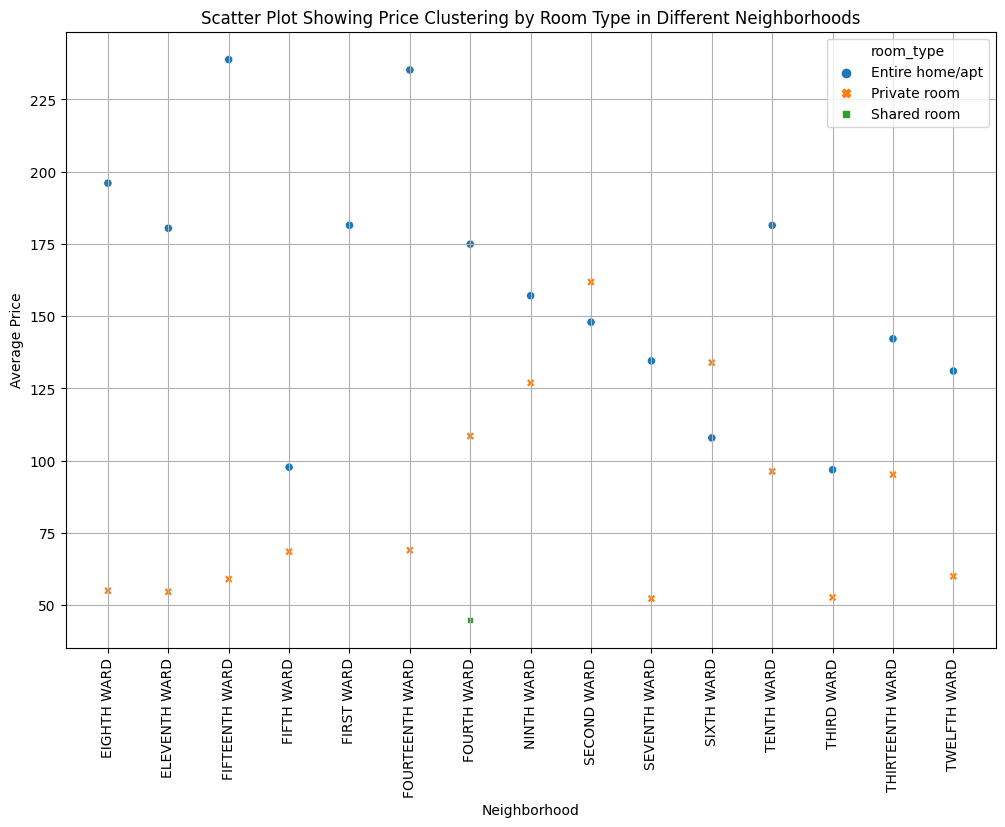

In [ ]:
# Creating a scatter plot for clustering visualization
plt.figure(figsize=(12, 8))

# Scatter plot of price vs. neighborhood for each room type
sns.scatterplot(x='neighbourhood', y='price', hue='room_type', data=average_prices_sorted, style='room_type')

# Improving plot aesthetics
plt.xticks(rotation=90)
plt.title('Scatter Plot Showing Price Clustering by Room Type in Different Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.grid(True)

# Displaying the plot
plt.show()

# Consumer Preference Analysis: Analyze consumer preferences and trends based on reviews and booking data (e.g., most preferred types of accommodations, seasonal trends).


In [ ]:
reviews_columns = reviews_df.columns

reviews_columns


Index(['listing_id', 'date'], dtype='object')

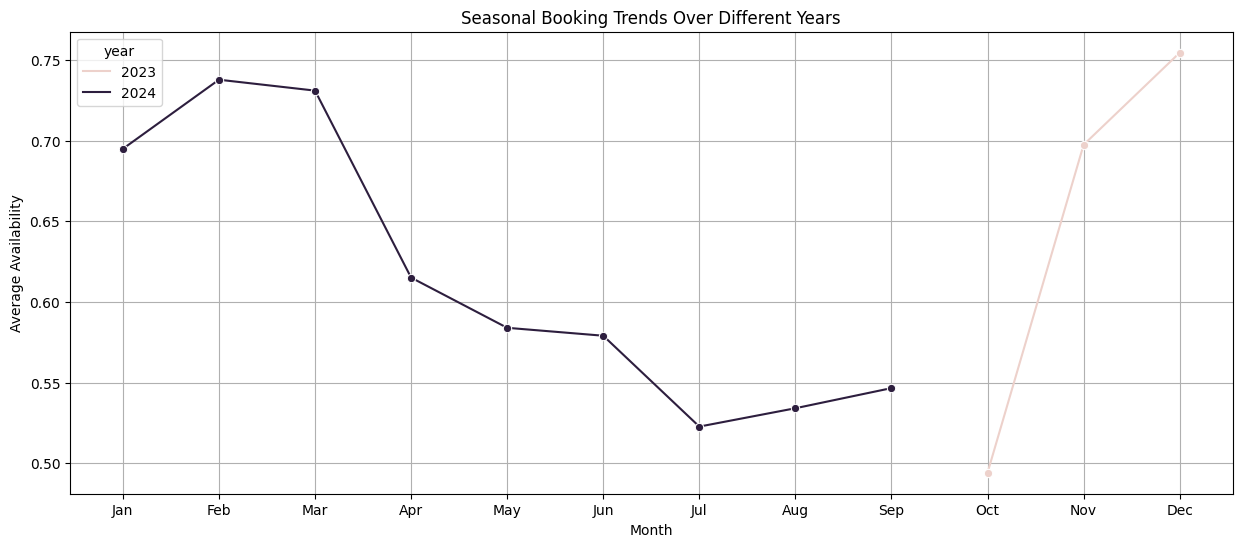

In [ ]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Extracting year and month for seasonal trend analysis
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month

# Converting 'available' column to a binary format for easier analysis (f = 0, t = 1)
calendar_df['available'] = calendar_df['available'].map({'f': 0, 't': 1})

# Grouping by year and month, and calculating the average availability
seasonal_trends = calendar_df.groupby(['year', 'month'])['available'].mean().reset_index()

# Plotting the seasonal trends
plt.figure(figsize=(15, 6))
sns.lineplot(x='month', y='available', hue='year', data=seasonal_trends, marker='o')

# Enhancing the plot
plt.title('Seasonal Booking Trends Over Different Years')
plt.xlabel('Month')
plt.ylabel('Average Availability')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)

# Displaying the plot
plt.show()

In [ ]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 390
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              391 non-null    int64  
 1   name                            391 non-null    object 
 2   host_id                         391 non-null    int64  
 3   host_name                       391 non-null    object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   391 non-null    object 
 6   latitude                        391 non-null    float64
 7   longitude                       391 non-null    float64
 8   room_type                       391 non-null    object 
 9   price                           391 non-null    float64
 10  minimum_nights                  391 non-null    int64  
 11  number_of_reviews               391 non-null    int64  
 12  last_review                     345 

In [ ]:


# Extracting latitude and longitude for the first 100 listings for demonstration purposes
sample_listings = listings_df[['latitude', 'longitude','price','room_type']].head(100)

# Creating a base map
map = folium.Map(location=[sample_listings['latitude'].mean(), sample_listings['longitude'].mean()], zoom_start=13)

# Adding markers for the listings
for idx, row in sample_listings.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']]).add_to(map)

# Displaying the map
map

In [ ]:
# Creating a base map with the average location from the sample listings
map_with_markers = folium.Map(location=[sample_listings['latitude'].mean(), sample_listings['longitude'].mean()], zoom_start=13)

# Adding markers to the map with popup information
for idx, row in sample_listings.iterrows():
    popup_info = f"Latitude: {row['latitude']}, Longitude: {row['longitude']}, Price: ${row['price']}, Room Type: {row['room_type']}"
    folium.Marker(location=[row['latitude'], row['longitude']], popup=popup_info).add_to(map_with_markers)

# Saving the map to an HTML file
map_file_path = './listings_map.html'
map_with_markers.save(map_file_path)

map_file_path


'./listings_map.html'